
---
# 03. Modelowanie ML - NYC Taxi 2016

Ten notebook zawiera trening i ewaluację modeli ML:
1. Random Forest - klasyfikacja wysokich napiwków
2. Linear Regression - predykcja kwoty przejazdu

---

In [1]:
pip install pymongo

Note: you may need to restart the kernel to use updated packages.


In [2]:
# %% Importy
import sys
sys.path.append('/home/jovyan')

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from src.data_loader import DataLoader
from src.preprocessing import DataPreprocessor
from src.features import FeatureEngineer
from src.models import ModelTrainer
from config.spark_config import MONGODB_CONFIG, ML_CONFIG

plt.style.use('seaborn-v0_8-whitegrid')
print("Biblioteki załadowane!")

Biblioteki załadowane!


## 3.1 Przygotowanie Danych

In [3]:
loader = DataLoader()
df_raw = loader.load_data()

preprocessor = DataPreprocessor()
df_cleaned = preprocessor.clean_data(df_raw)

feature_engineer = FeatureEngineer()
df_features = feature_engineer.create_all_features(df_cleaned)

df_features.cache()
print(f"Dane gotowe: {df_features.count():,} rekordów")

Tworzenie sesji Spark...
Spark UI: http://localhost:4040
Master: local[*]
Spark Version: 3.5.0
Python Version: 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]

Wczytywanie danych z: /home/jovyan/data/yellow_tripdata_2015-*.csv
⚠️  UWAGA: Nie znaleziono plików pasujących do wzorca: /home/jovyan/data/yellow_tripdata_2015-*.csv
Upewnij się, że pliki CSV znajdują się w folderze 'data/'
✓ Wczytano 12,748,986 rekordów w 8.67 sekund

CZYSZCZENIE DANYCH (początkowa liczba: 12,748,986)
  Przed: 12,748,986
  Po:    12,418,683
  Usunięto: 330,303 (2.59%)

TWORZENIE NOWYCH CECH...
Utworzono cechy:
  - Czasowe: pickup_hour, pickup_day, pickup_month, is_weekend, is_rush_hour, is_night
  - Przejazdu: trip_duration_min, speed_mph, distance_category
  - Napiwków: tip_percentage, high_tip
Dane gotowe: 12,401,881 rekordów


## 3.2 Przygotowanie do Modelowania

In [4]:
numeric_features = feature_engineer.get_numeric_features()
categorical_features = feature_engineer.get_categorical_features()

print("Cechy numeryczne:", numeric_features)
print("Cechy kategoryczne:", categorical_features)

# %% Przygotowanie danych ML
df_ml = df_features.select(
    numeric_features + categorical_features +
    ["tip_percentage", "high_tip", "total_amount", "fare_amount"]
).dropna()

# Dane do klasyfikacji (tylko płatności kartą)
df_ml_tips = df_ml.filter(col("payment_type") == 1)

print(f"\nDane do modelowania napiwków: {df_ml_tips.count():,}")
print(f"Dane do modelowania kwoty: {df_ml.count():,}")

# %% Sprawdzenie balansu klas
print("\nRozkład klasy docelowej (high_tip):")
df_ml_tips.groupBy("high_tip").count().show()

# %% Podział danych
train_ratio = ML_CONFIG["train_test_split"]
seed = ML_CONFIG["seed"]

train_class, test_class = df_ml_tips.randomSplit([train_ratio, 1-train_ratio], seed=seed)
train_reg, test_reg = df_ml.randomSplit([train_ratio, 1-train_ratio], seed=seed)

print(f"\nKlasyfikacja - Train: {train_class.count():,}, Test: {test_class.count():,}")
print(f"Regresja - Train: {train_reg.count():,}, Test: {test_reg.count():,}")

# Cache
train_class.cache()
test_class.cache()
train_reg.cache()
test_reg.cache()


Cechy numeryczne: ['passenger_count', 'trip_distance', 'pickup_hour', 'pickup_day', 'pickup_month', 'is_weekend', 'is_rush_hour', 'is_night']
Cechy kategoryczne: ['VendorID', 'RatecodeID', 'payment_type']

Dane do modelowania napiwków: 7,695,714
Dane do modelowania kwoty: 12,401,881

Rozkład klasy docelowej (high_tip):
+--------+-------+
|high_tip|  count|
+--------+-------+
|       1|4773200|
|       0|2922514|
+--------+-------+


Klasyfikacja - Train: 6,155,558, Test: 1,540,156
Regresja - Train: 9,920,622, Test: 2,481,259


DataFrame[passenger_count: int, trip_distance: double, pickup_hour: int, pickup_day: int, pickup_month: int, is_weekend: int, is_rush_hour: int, is_night: int, VendorID: int, RatecodeID: int, payment_type: int, tip_percentage: double, high_tip: int, total_amount: double, fare_amount: double]

## 3.3 Model 1: Random Forest (Klasyfikacja)

In [5]:
trainer = ModelTrainer()

# Przygotowanie pipeline cech
preprocessing_stages = trainer.prepare_features_pipeline(
    numeric_features, 
    categorical_features
)

# %% Trening Random Forest
gbt_results = trainer.train_gbt_classifier(
    train_class,         
    test_class,
    preprocessing_stages,
    label_col="high_tip"
)

# %% Feature Importance
print("\nTOP 10 NAJWAŻNIEJSZYCH CECH (Gradient Boosted Trees):")
print(gbt_results["feature_importance"].head(10).to_string(index=False))

# %% Macierz pomyłek
print("\nMACIERZ POMYŁEK:")
gbt_results["predictions"].groupBy("high_tip", "prediction").count() \
    .orderBy("high_tip", "prediction").show()



TRENING MODELU: GBT CLASSIFIER
Trening modelu...
Czas treningu: 91.82 sekund
Wykonywanie predykcji...

────────────────────────────────────────
METRYKI GBT CLASSIFIER
────────────────────────────────────────
  AUC-ROC:    0.6703
  Accuracy:   0.6820
  F1-Score:   0.6594
  Precision:  0.6730
  Recall:     0.6820

TOP 10 NAJWAŻNIEJSZYCH CECH (Gradient Boosted Trees):
        feature  importance
    pickup_hour    0.291065
  trip_distance    0.231943
   VendorID_idx    0.188920
       is_night    0.137149
     pickup_day    0.059618
     is_weekend    0.047801
 RatecodeID_idx    0.024330
   is_rush_hour    0.016385
passenger_count    0.002788
   pickup_month    0.000000

MACIERZ POMYŁEK:
+--------+----------+------+
|high_tip|prediction| count|
+--------+----------+------+
|       0|       0.0|222352|
|       0|       1.0|362490|
|       1|       0.0|127223|
|       1|       1.0|828091|
+--------+----------+------+



## 3.4 Model 2: Linear Regression (Regresja)

In [6]:
# %% Trening Linear Regression
lr_results = trainer.train_linear_regression(
    train_reg,
    test_reg,
    preprocessing_stages,
    label_col="total_amount"
)

# %% Współczynniki regresji
print(f"\nIntercept: {lr_results['intercept']:.4f}")
print("\nWspółczynniki regresji (top 10):")
print(lr_results["coefficients"].head(10).to_string(index=False))



TRENING MODELU: LINEAR REGRESSION
Trening modelu...
Czas treningu: 16.39 sekund
Wykonywanie predykcji...

────────────────────────────────────────
METRYKI LINEAR REGRESSION
────────────────────────────────────────
  RMSE:  3.2894
  MAE:   1.8308
  R²:    0.9195

Intercept: 14.7064

Współczynniki regresji (top 10):
         feature  coefficient  abs_coef
   trip_distance    10.149741 10.149741
  RatecodeID_idx     1.352741  1.352741
payment_type_idx    -1.182715  1.182715
      is_weekend    -0.292883  0.292883
    is_rush_hour     0.112985  0.112985
        is_night    -0.112494  0.112494
      pickup_day     0.103202  0.103202
     pickup_hour     0.067797  0.067797
    VendorID_idx     0.019397  0.019397
 passenger_count     0.000000  0.000000


## 3.5 Podsumowanie Modeli

In [7]:
summary_df = trainer.get_summary()
print("\n" + "=" * 80)
print("PODSUMOWANIE MODELI")
print("=" * 80)
print(summary_df.to_string(index=False))


PODSUMOWANIE MODELI
            Model      Zadanie Główna metryka                 Dodatkowe Czas (s)
   GBT Classifier Klasyfikacja    AUC: 0.6703   Acc: 0.6820, F1: 0.6594    91.82
Linear Regression     Regresja     R²: 0.9195 RMSE: 3.2894, MAE: 1.8308    16.39


## 3.6 Wizualizacje Wyników

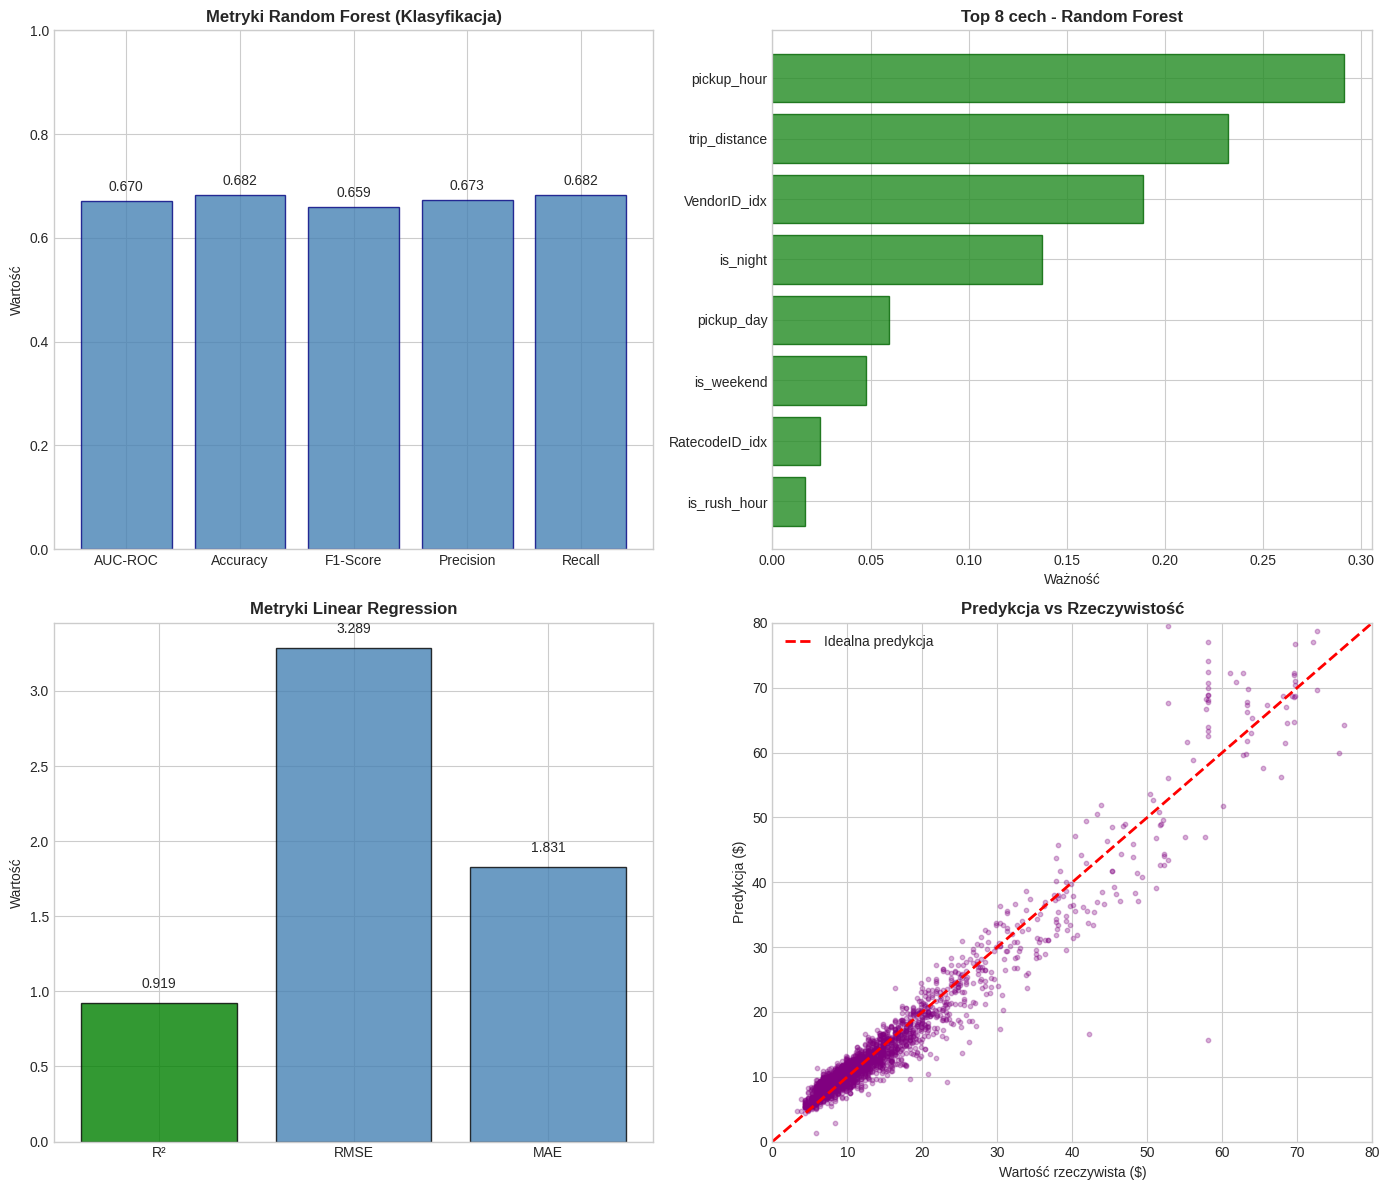

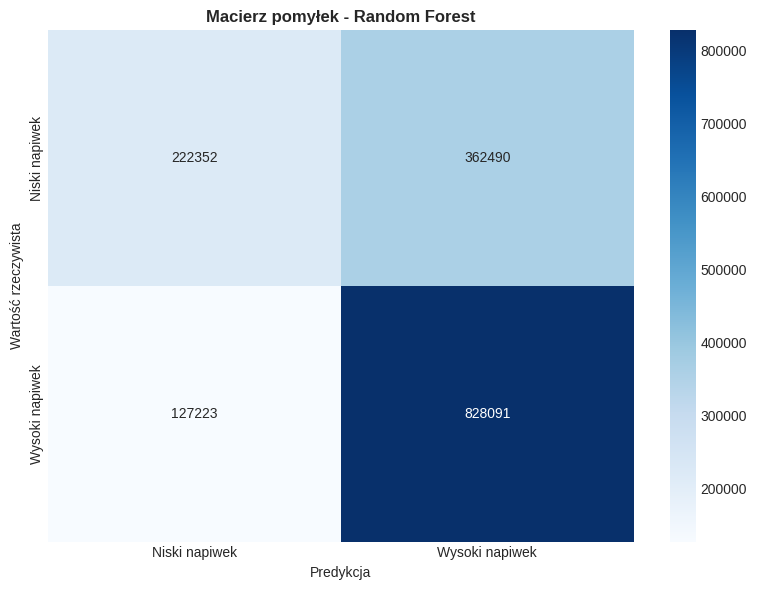

In [8]:
# %% Wykres 1: Metryki modeli
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Metryki klasyfikacji
rf_metrics = trainer.metrics["gbt_classifier"]
metrics_class = ['AUC-ROC', 'Accuracy', 'F1-Score', 'Precision', 'Recall']
values_class = [rf_metrics['auc_roc'], rf_metrics['accuracy'], 
                rf_metrics['f1_score'], rf_metrics['precision'], rf_metrics['recall']]

bars1 = axes[0, 0].bar(metrics_class, values_class, color='steelblue', 
                        edgecolor='navy', alpha=0.8)
axes[0, 0].set_ylabel("Wartość")
axes[0, 0].set_title("Metryki Random Forest (Klasyfikacja)", fontweight='bold')
axes[0, 0].set_ylim(0, 1)
for bar, val in zip(bars1, values_class):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{val:.3f}', ha='center', fontsize=10)

# Feature Importance RF
importance_rf = trainer.feature_importance["gbt_classifier"].head(8)
axes[0, 1].barh(importance_rf['feature'], importance_rf['importance'],
                color='forestgreen', edgecolor='darkgreen', alpha=0.8)
axes[0, 1].set_xlabel("Ważność")
axes[0, 1].set_title("Top 8 cech - Random Forest", fontweight='bold')
axes[0, 1].invert_yaxis()

# Metryki regresji
lr_metrics = trainer.metrics["linear_regression"]
metrics_reg = ['R²', 'RMSE', 'MAE']
values_reg = [lr_metrics['r2'], lr_metrics['rmse'], lr_metrics['mae']]

bars2 = axes[1, 0].bar(metrics_reg, values_reg, 
                        color=['green' if lr_metrics['r2'] > 0.7 else 'orange', 
                               'steelblue', 'steelblue'],
                        edgecolor='black', alpha=0.8)
axes[1, 0].set_ylabel("Wartość")
axes[1, 0].set_title("Metryki Linear Regression", fontweight='bold')
for bar, val in zip(bars2, values_reg):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{val:.3f}', ha='center', fontsize=10)

# Predykcja vs Rzeczywistość
pred_sample = lr_results["predictions"].select("total_amount", "prediction") \
    .sample(fraction=0.001, seed=42).toPandas()

axes[1, 1].scatter(pred_sample["total_amount"], pred_sample["prediction"],
                   alpha=0.3, s=10, color='purple')
axes[1, 1].plot([0, 100], [0, 100], 'r--', linewidth=2, label='Idealna predykcja')
axes[1, 1].set_xlabel("Wartość rzeczywista ($)")
axes[1, 1].set_ylabel("Predykcja ($)")
axes[1, 1].set_title("Predykcja vs Rzeczywistość", fontweight='bold')
axes[1, 1].set_xlim(0, 80)
axes[1, 1].set_ylim(0, 80)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/06_model_results.png', dpi=150)
plt.show()

# %% Wykres 2: Macierz pomyłek
cm_data = gbt_results["predictions"].groupBy("high_tip", "prediction").count().toPandas()
cm_pivot = cm_data.pivot(index='high_tip', columns='prediction', values='count').fillna(0)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_pivot, annot=True, fmt='.0f', cmap='Blues',
            xticklabels=['Niski napiwek', 'Wysoki napiwek'],
            yticklabels=['Niski napiwek', 'Wysoki napiwek'], ax=ax)
ax.set_xlabel("Predykcja")
ax.set_ylabel("Wartość rzeczywista")
ax.set_title("Macierz pomyłek - Random Forest", fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/07_confusion_matrix.png', dpi=150)
plt.show()


## 3.7 Zapis Wyników do MongoDB

In [9]:
client = MongoClient(MONGODB_CONFIG["uri"])
db = client[MONGODB_CONFIG["database"]]

# %% Zapis wyników
model_results = {
    "timestamp": datetime.now().isoformat(),
    "dataset": "NYC Yellow Taxi 2016",
    "models": {
        "gbt_classifier": {
            "task": "classification",
            "target": "high_tip",
            "metrics": {
                "auc_roc": float(rf_metrics['auc_roc']),
                "accuracy": float(rf_metrics['accuracy']),
                "f1_score": float(rf_metrics['f1_score']),
                "precision": float(rf_metrics['precision']),
                "recall": float(rf_metrics['recall'])
            },
            "training_time_seconds": float(rf_metrics['training_time']),
            "feature_importance": trainer.feature_importance["gbt_classifier"].head(10).to_dict('records')
        },
        "linear_regression": {
            "task": "regression",
            "target": "total_amount",
            "metrics": {
                "rmse": float(lr_metrics['rmse']),
                "mae": float(lr_metrics['mae']),
                "r2": float(lr_metrics['r2'])
            },
            "training_time_seconds": float(lr_metrics['training_time']),
            "coefficients": trainer.feature_importance["linear_regression"].head(10).to_dict('records')
        }
    }
}

db.model_results.drop()
db.model_results.insert_one(model_results)
print("Wyniki zapisane do MongoDB (kolekcja: model_results)")


Wyniki zapisane do MongoDB (kolekcja: model_results)


## 3.8 Podsumowanie

In [10]:
print("""
================================================================================
                         PODSUMOWANIE MODELOWANIA ML
================================================================================

1. RANDOM FOREST (Klasyfikacja wysokich napiwków):
   - AUC-ROC:  {:.4f}
   - Accuracy: {:.4f}
   - F1-Score: {:.4f}
   - Najważniejsze cechy: payment_type, trip_distance, pickup_hour

2. LINEAR REGRESSION (Predykcja kwoty przejazdu):
   - R²:   {:.4f}
   - RMSE: {:.4f} $
   - MAE:  {:.4f} $

3. WNIOSKI:
   - Random Forest dobrze klasyfikuje wysokie napiwki
   - Regresja liniowa dobrze przewiduje typowe kwoty przejazdów
   - Typ płatności jest kluczowy dla napiwków (karta >> gotówka)
   - Dystans i godzina mają znaczący wpływ na wyniki

================================================================================
""".format(
    rf_metrics['auc_roc'], rf_metrics['accuracy'], rf_metrics['f1_score'],
    lr_metrics['r2'], lr_metrics['rmse'], lr_metrics['mae']
))

# %% Zamknięcie
client.close()
# loader.spark.stop()  # Odkomentuj aby zamknąć Spark
print("Analiza zakończona!")


                         PODSUMOWANIE MODELOWANIA ML

1. RANDOM FOREST (Klasyfikacja wysokich napiwków):
   - AUC-ROC:  0.6703
   - Accuracy: 0.6820
   - F1-Score: 0.6594
   - Najważniejsze cechy: payment_type, trip_distance, pickup_hour

2. LINEAR REGRESSION (Predykcja kwoty przejazdu):
   - R²:   0.9195
   - RMSE: 3.2894 $
   - MAE:  1.8308 $

3. WNIOSKI:
   - Random Forest dobrze klasyfikuje wysokie napiwki
   - Regresja liniowa dobrze przewiduje typowe kwoty przejazdów
   - Typ płatności jest kluczowy dla napiwków (karta >> gotówka)
   - Dystans i godzina mają znaczący wpływ na wyniki


Analiza zakończona!
